In [1]:
#normalize, categorize, dummify features in dataframe
from sklearn import preprocessing
import pandas as pd
import numpy as np
import operator
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#read in pickled final movie dataframe
finalMovie_df = pd.read_csv('finalMovie_df.csv')

#drop columns, lack of sufficient data, unimportant, some maybe I could come back around to
finalMovie_df.drop('tomatoURL', axis=1, inplace=True)
finalMovie_df.drop('BoxOffice', axis=1, inplace=True)
finalMovie_df.drop('Writer', axis=1, inplace=True)
finalMovie_df.drop('Website', axis=1, inplace=True)
finalMovie_df.drop('tomatoConsensus', axis=1, inplace=True)
finalMovie_df.drop('tomatoImage', axis=1, inplace=True)
finalMovie_df.drop('Poster', axis=1, inplace=True)
finalMovie_df.drop('Metascore', axis=1, inplace=True)
finalMovie_df.drop('Response', axis=1, inplace=True)
finalMovie_df.drop('Released', axis=1, inplace=True)
finalMovie_df.drop('tomatoUserReviews', axis=1, inplace=True)
finalMovie_df.drop('DVD', axis=1, inplace=True)
finalMovie_df.drop('imdbID', axis=1, inplace=True)
finalMovie_df.drop('Type', axis=1, inplace=True)
finalMovie_df.drop('Production', axis=1, inplace=True)
finalMovie_df.drop('tomatoFresh', axis=1, inplace=True)
finalMovie_df.drop('tomatoReviews', axis=1, inplace=True)
finalMovie_df.drop('tomatoRotten', axis=1, inplace=True)
finalMovie_df.drop('tomatoUserMeter', axis=1, inplace=True)
finalMovie_df.drop('Unnamed: 0', axis=1, inplace=True)

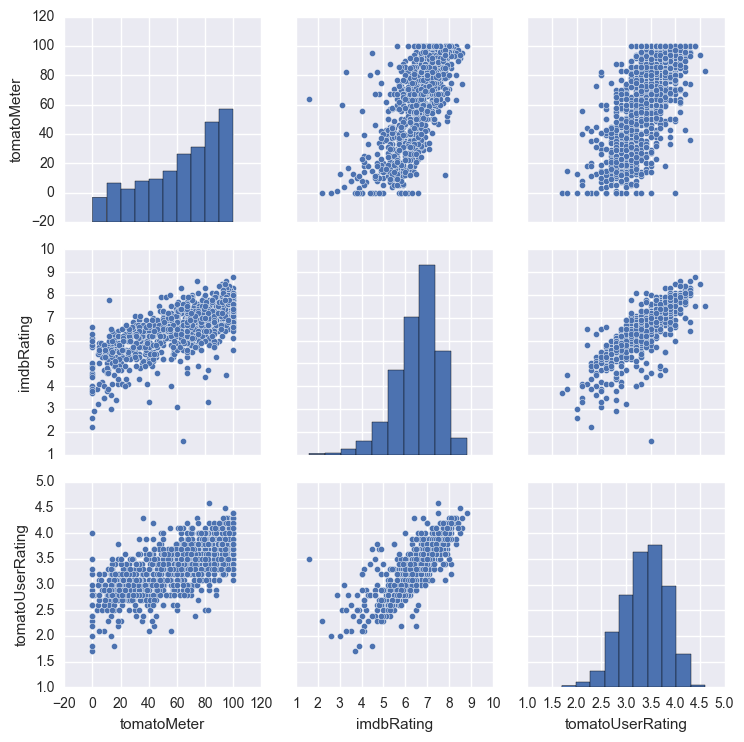

In [2]:
ppdata = finalMovie_df[['tomatoMeter', 'imdbRating', 'tomatoUserRating']].query('imdbRating == imdbRating and tomatoMeter == tomatoMeter and tomatoUserRating == tomatoUserRating')
sns.pairplot(ppdata.sample(n = 1000))
#the lines we see here in the pairplot are our values that we filled in with the linear regression

In [3]:
#Run linear regressions to populate some of the null values in rankings/user and critics
finalMovie_df["imdbRating"].fillna(lambda x: random.choice(finalMovie_df[finalMovie_df['imdbRating'] != np.nan]["imdbRating"]), inplace =True)

def tofloat(x):
    try:
        x = float(x)
        return x
    except:
        return 3.5
    
#create dataframe querying from tomatoMeter, imdbRating and User rating where tomatoMeter is not N/A
train = finalMovie_df[['tomatoMeter', 'imdbRating', 'tomatoUserRating']].query('tomatoMeter==tomatoMeter')

train['imdbRating'] = train['imdbRating'].apply(tofloat)
TrainTom = train['tomatoMeter']
TrainImdb = train[['imdbRating']]

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(TrainImdb, TrainTom, test_size=0.4, random_state=101)

#create instance of Linear Regression class
linreg = LinearRegression()

#fit the linear regression using training data
linreg.fit(TrainImdb, TrainTom)

#define function that will use linear regression to predict missing value
def preddata(x):
    y = linreg.predict(x)
    z = y[0]
    return z

#create new dataframe with the missing values
missingvals = finalMovie_df[['tomatoMeter', 'imdbRating', 'tomatoUserRating']].query('tomatoMeter != tomatoMeter')

missingvals['imdbRating'] = missingvals['imdbRating'].apply(tofloat)

#pass through 'imdbRating' (our dependent variable) and apply linear regression to each value
#add predicted value of lin. regression to column with N/A values
missingvals['tomatoMeter'] = missingvals['imdbRating'].apply(preddata)

# #concatanate the two dataframes we separated and sort it by index
frames = [missingvals, train]
populatednulls_df = pd.concat(frames)

populatednulls_df = populatednulls_df.sort_index()

In [5]:
#repeat procedure for tomatoUserRating
train2 = populatednulls_df[['tomatoMeter', 'imdbRating', 'tomatoUserRating']].query('tomatoUserRating == tomatoUserRating')

train2['tomatoUserRating'] = train2['tomatoUserRating'].apply(tofloat)
#training data
trainTom = train2['tomatoUserRating']
traindata = train2[['imdbRating']]  

linreg = LinearRegression()
linreg.fit(traindata, trainTom)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
#had empty values that were converted to N/A for purposes of querying dataframe
# populatednulls_df['tomatoUserRating'] = populatednulls_df['tomatoUserRating'].apply(UserRating)

#query dataframe for rows where tomatoUserRating is 'N/A'
missingvals2 = populatednulls_df[['tomatoMeter', 'imdbRating', 'tomatoUserRating']].query('tomatoUserRating !=tomatoUserRating')

missingvals2['tomatoUserRating'] = missingvals2['imdbRating'].apply(preddata)

In [7]:
from sklearn import preprocessing

frames = [missingvals2, train2]
populatednullsfinal_df = pd.concat(frames)
populatednullsfinal_df = populatednullsfinal_df.sort_index()

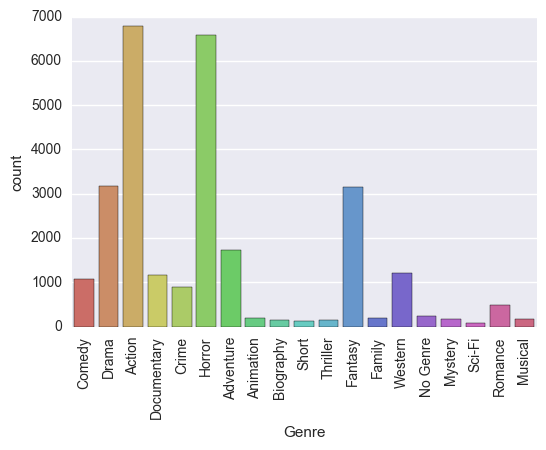

In [8]:
#Genre

#split by commas and if 'N/A' return 'No Genre', ordered by importance so take first genre listed
def genresplit(x):
    try:
        y = x.split(",")
        if y[0] == 'N/A':
            return 'No Genre'
        else:
            return y[0]
    except:
        return 'No Genre'

#apply the functions to 'Genre' column and create two new columns, then dummify and 
#add back to original dataframe
finalMovie_df['Genre'] = finalMovie_df['Genre'].apply(genresplit)

finalMovie_df['Genre-count'] = finalMovie_df.groupby('Genre')['Genre'].transform('count')
finalMovie_df['Count'] = finalMovie_df.apply(lambda row: row['Genre-count'], axis=1)
genredata = finalMovie_df[['Genre', 'Count']].query('Count > 50')


mypalette = sns.set_palette("hls", 8)
genre = sns.countplot(x='Genre',data=genredata, palette="hls")
sns.despine()
genre.set_xticklabels(labels = genredata["Genre"].value_counts().index.tolist(), rotation=90)

Genredummy = pd.get_dummies(finalMovie_df['Genre'])
finalMovie_df = pd.concat([finalMovie_df, Genredummy], axis=1)

finalMovie_df.drop('Genre', axis=1, inplace=True)
finalMovie_df.drop('Genre-count', axis=1, inplace=True)
finalMovie_df.drop('Count', axis=1, inplace=True)

In [9]:
#Language
#people like domestic or international movies, or maybe have particular affinity to a well known
#countrys' movies but more exotic cinema can be grouped together
#exist fanatics of Spanish language film but not Xhosa language'
languages = ['Arabic','Bulgarian','Chinese','Croatian',\
             'Dutch', 'English', 'Finnish', 'French','German',\
             'Greek','Hebrew','Hindi', 'Hungarian', 'Icelandic',\
             'Italian', 'Japanese', 'Korean', 'Norwegian',\
             'Persian','Polish', 'Portuguese', 'Punjabi',\
             'Romanian', 'Russian', 'Spanish','Swedish', \
             'Turkish', 'Ukrainian']

#split languages by comma, if not in major language list return 'secondary language'
def languagesplit(x):
    try: 
        y = x.split(",")
        if y[0] == 'N/A':
            return 'No Language'
        else:
            if y[0] in languages:
                return y[0]
            else:
                return 'Secondary language'
    except:
        return 'No Language'


finalMovie_df['Language'] = finalMovie_df['Language'].apply(languagesplit)

Languagedummy = pd.get_dummies(finalMovie_df['Language'])
finalMovie_df = pd.concat([finalMovie_df, Languagedummy], axis=1)

finalMovie_df.drop('Language', axis=1, inplace=True)

In [10]:
#Country-same idea as language
maincountries = ['Argentina', 'Australia', 'Austria', 'Belgium', \
                 'Brazil', 'Bulgaria', 'Canada', 'China', 'Chile',\
                 'Colombia', 'Costa Rica', 'Czech Republic', 'Denmark',\
                 'Finland', 'France', 'Germany', 'Greece','Hong Kong',\
                 'Hungary', 'Iceland', 'India','Iran', 'Ireland', 'Italy',\
                 'Japan','Malaysia', 'Mexico', 'Netherlands', 'New Zealand',\
                 'Pakistan', 'Poland', 'Portugal', 'Romania','Russia',\
                 'Singapore', 'South Africa', 'Spain','Sweden',\
                 'Switzerland', 'Thailand', 'UK','USA', 'Soviet Union', 'West Germany']

def countrysplit(x):
    try:
        y = x.split(",")
        if y[0] == 'N/A':
            return 'No Country'
        else:
            if y[0] in maincountries:
                return y[0]
            else: 
                return 'Small market country' 
    except:
        return 'No Country'
    

finalMovie_df['Country'] = finalMovie_df['Country'].apply(countrysplit)
Countrydummy = pd.get_dummies(finalMovie_df['Country'])
finalMovie_df = pd.concat([finalMovie_df, Countrydummy], axis=1)

finalMovie_df.drop('Country', axis=1, inplace=True)

In [11]:
#imdbVotes

def sample(x):
    try:
        while x == 'N/A':
            y = finalMovie_df['imdbVotes'].sample()
            try:
                y = y.iloc[0]
                x = float(y.replace(',',''))
                return x
            except:
                continue
        else:
            x = float(x.replace(',',''))
            return x
    except:
        return 0
finalMovie_df['imdbVotes'] = finalMovie_df['imdbVotes'].apply(sample)

In [12]:
#Awards                             
#number of wins
#number of columns
#pull out number of award nominations for one column and then number of wins in another
#also have the option of using amount of Oscar wins, Emmy wins, etc.

def wins_split(x):
    try:
        y = x.split(" ")
        if len(y) > 1:
            try: 
                y[1] == 'win'
                return int(y[0])
            except:
                try:
                    y[3] == 'Another'
                    z = int(y[4]) + int(y[1])
                    return z
                except:
                    try:
                        y[4] == 'Another'
                        z = int(y[5]) + int(y[1])
                        return z
                    except:
                        return 0
        else: 
            return 0
    except:
        return 0

def nom_split(x):
    try:
        y = x.split(" ")
        if len(y) > 1:
            try: 
                y[1] == 'nomination'
                return int(y[0])
            except:
                try:
                    y[2] == '&'
                    z = int(y[3])
                    return z
                except:
                    try:
                        y[8] == 'nominations'
                        z = int(y[7])
                        return z
                    except:
                        try:
                            y[9] == 'nominations'
                            z = int(y[8])
                            return z
                        except:
                            return 0
        else: 
            return 0
    except:
        return 0

finalMovie_df['Award_wins'] = finalMovie_df['Awards'].apply(wins_split)
finalMovie_df['Award_noms'] = finalMovie_df['Awards'].apply(nom_split)
finalMovie_df.drop('Awards', axis=1, inplace=True)
finalMovie_df['Award_winner'] = finalMovie_df['Award_wins'].apply(lambda x: 'Award Winner' if x > 0 else 'No Awards')

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


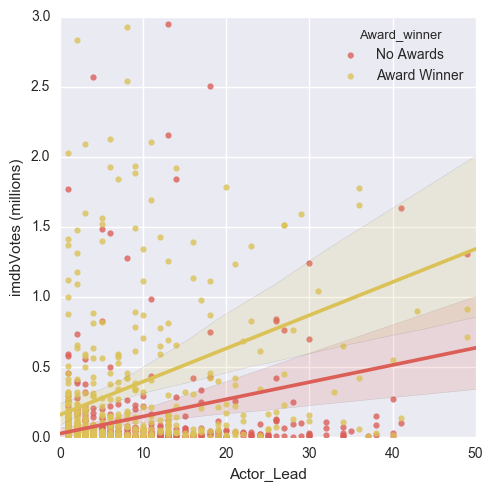

In [13]:
#Actors- using a moviestar factor, how many movies has actor been in throughout entire dataframe
#people watch movies not for specific actor (this is my supposition) but if it is big budget vs.
#independent movie

#as before, split actors on comma
def actorsplit(x):
    try: 
        y = x.split(",")
        if y[0] == 'N/A':
            return 'No Actor'
        else:
            return y[0]
    except:
        return 'No Actor'

#use groupby function to sum up amount of movies in which actor has appeared
#use lambda function to then assign this value to new columns
finalMovie_df['Actor_Lead'] = finalMovie_df['Actors'].apply(actorsplit)
finalMovie_df['Actor_LeadSQ'] = finalMovie_df.groupby('Actor_Lead')['Actor_Lead'].transform('count')
finalMovie_df['Actor_Lead'] = finalMovie_df.apply(lambda row: row['Actor_LeadSQ'], axis=1)
finalMovie_df.drop('Actors', axis=1, inplace=True)
finalMovie_df.drop('Actor_LeadSQ', axis=1, inplace=True)

actordata = finalMovie_df[['Actor_Lead', 'imdbVotes', 'Award_winner']].query('Actor_Lead < 50 and imdbVotes < 4000000').sample(frac=0.05)
actordata['imdbVotes (millions)'] = actordata['imdbVotes'].apply(lambda x: x/100000)
ax = sns.lmplot(x= 'Actor_Lead', y='imdbVotes (millions)', data=actordata, hue='Award_winner', legend_out = False)
axes = ax.axes
axes[0,0].set_ylim(0,3)
axes[0,0].set_xlim(0,50)

#still need to normalize these values
finalMovie_df['Actor_Lead'] = preprocessing.scale(finalMovie_df['Actor_Lead'])
finalMovie_df['Award_wins'] = preprocessing.scale(finalMovie_df['Award_wins'])
finalMovie_df['Award_noms'] = preprocessing.scale(finalMovie_df['Award_noms'])
finalMovie_df['imdbVotes'] = preprocessing.scale(finalMovie_df['imdbVotes'])
finalMovie_df.drop('Award_winner', axis=1, inplace=True)

In [14]:
#Directors

def directorsplit(x):
    try:
        y = x.split(",")
        if y[0] == 'N/A':
            return 'No Director'
        else:
            return y[0]
    except: 
        return 'No Director'


finalMovie_df['Director'] = finalMovie_df['Director'].apply(directorsplit)
finalMovie_df.groupby('Director').count()

#to avoid having unimportant features, group one-time directors into one feature
finalMovie_df['DirectorSQ'] = finalMovie_df.groupby('Director')['Director'].transform('count')
finalMovie_df['Director'] = finalMovie_df.apply(lambda row: 'one-timer' if row['DirectorSQ'] < 25 else row['Director'], axis=1)

#dummify the column
Directordummy = pd.get_dummies(finalMovie_df['Director'])
finalMovie_df = pd.concat([finalMovie_df, Directordummy], axis=1)

finalMovie_df.drop('Director', axis=1, inplace=True)
finalMovie_df.drop('DirectorSQ', axis=1, inplace=True)

In [15]:
#Runtime
#Convert from hours to minutes where needed, normailize

def hour2min(x):
    try:
        y = x.split(" ")
        if y[1] == 'min':
            try:
                minutes = float(y[0])
                return minutes
            except:
                minutes = y[0]
                return 'N/A'
        elif y[1] == 'h':
            minutes = float(y[0])*60
            minutes = minutes + float(y[2])
            return minutes
        else:
            minutes = 'N/A'
            return minutes
    except:
        return 'N/A'
    
def sample(x):
    if x != x:
        while x != x:
            y = finalMovie_df['Runtime'].sample()
            try: 
                y = float(y)
            except:
                return 60
        return y
    else:
        if type(x) == float:
            return x
        else: 
            return 60.

def tofloat(x):
    try:
        x = float(x)
        return x
    except:
        return None


finalMovie_df['Runtime'] = finalMovie_df['Runtime'].apply(hour2min).apply(tofloat).apply(sample)
finalMovie_df['Runtime'] = preprocessing.scale(finalMovie_df['Runtime'])

In [16]:
#standardize year(not classify/dummify)
finalMovie_df['Year'] = finalMovie_df['Year'].str[0:4].astype(int)
def decade(x):
    if x in range(0,1951):
        x = 1950
    elif x in range(1951,1961):
        x = 1960
    elif x in range(1961,1971):
        x = 1970
    elif x in range(1971,1981):
        x = 1980
    elif x in range(1981, 1991):
        x = 1990
    elif x in range(1991,2001):
        x = 2000
    elif x in range(2001,2011):
        x = 2010
    else:
        x = 2020
    return x
finalMovie_df['Decade'] = finalMovie_df['Year'].apply(decade)

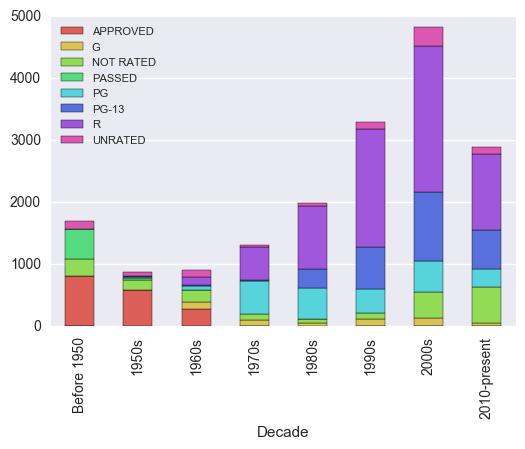

In [17]:
#Rated

def nullRated(x):
    if x != x:
        x = 'N/A'
        return x
    else:
        return x

finalMovie_df['Rated'] = finalMovie_df['Rated'].apply(nullRated)

#Get rid of N/A rated, take random sample 
finalMovie_df['Rated-count'] = finalMovie_df.groupby('Rated')['Rated'].transform('count')
finalMovie_df['Count'] = finalMovie_df.apply(lambda row: row['Rated-count'], axis=1)
rateddata = finalMovie_df[['Decade', 'Rated', 'Count']].query('Count > 500 and Rated != "N/A"')

my_xticks = ['Before 1950', '1950s','1960s' , '1970s','1980s', '1990s', '2000s', '2010-present']
current_palette = sns.color_palette("hls", 8)
rated = rateddata.groupby(['Decade','Rated']).Decade.count()
ax = rated.unstack().plot(kind='bar',stacked=True, grid=False, color = current_palette)
ax.yaxis.grid(True)
ax.set_xticklabels(my_xticks)
ax.legend(loc=2, prop={'size':8})

rateddummy = pd.get_dummies(finalMovie_df['Rated'])
finalMovie_df = pd.concat([finalMovie_df, rateddummy], axis=1)

finalMovie_df.drop('Rated', axis=1, inplace=True)
finalMovie_df.drop('Rated-count', axis=1, inplace=True)
finalMovie_df.drop('Count', axis=1, inplace=True)
finalMovie_df.drop('Decade', axis=1, inplace=True)
finalMovie_df['Year'] = preprocessing.scale(finalMovie_df['Year'])

In [18]:
#import modules to use for NLP that will be applied to the plot summary

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.decomposition import TruncatedSVD

#perform tf-idf on all of the plot summaries and fit/transform the sparse matrix

# tfidf = TfidfVectorizer(stop_words = 'english', strip_accents = 'unicode')
# X = tfidf.fit_transform(list(finalMovie_df['Plot']))


In [19]:
#create instance of SVD class, similar to Principal Component Analysis,
#Singular Value Decomposition is a factorization of a real or complex matrix
#and in this case used as an alternative form of dimensionality reduction 
#because matrix is sparse

# svd = TruncatedSVD(n_components= 4500)

In [20]:
# fit and transform matrix using SVD, rotating axes and transforming to original 'form'
# of my dataframe (with dimensions equal to number of components specified above)

# x = svd.fit_transform(X)

In [21]:
# print shape of matrix to confirm correct form

# x.shape 

In [22]:
# explained variance ratio, amount of variance maintained after performing SVD
# and reducing dimensions

# svd.explained_variance_ratio_ .sum()

In [23]:
# SVD = pd.DataFrame(x)

In [24]:
# with open('SVD.pkl', 'w') as picklefile:
#     pickle.dump(SVD, picklefile)

In [25]:
#drop final columns

finalMovie_df.drop('Plot', axis=1, inplace=True)
finalMovie_df.drop('Title', axis=1, inplace=True)
finalMovie_df.drop('tomatoRating ', axis=1, inplace=True)
finalMovie_df.drop('tomatoMeter', axis=1, inplace=True)
finalMovie_df.drop('tomatoUserRating', axis=1, inplace=True)
finalMovie_df.drop('imdbRating', axis=1, inplace=True)
finalMovie_df.drop('netflix', axis=1, inplace=True)
finalMovie_df.drop('hbo', axis=1, inplace=True)
finalMovie_df.drop('hulu', axis=1, inplace=True)
finalMovie_df.drop('showtime', axis=1, inplace=True)
finalMovie_df.drop('amazon', axis=1, inplace=True)
finalMovie_df.drop('movieId', axis=1, inplace=True)

FinalMovieNorm_df = pd.concat([finalMovie_df, populatednullsfinal_df], axis=1)

In [28]:
#key dataframe will be indentifier for movie and indicate the service where
#movie can be found

with open('key_df.pkl', 'r') as picklefile:
    key_df = pickle.load(picklefile)
    
key_df['futureindex'] = [x for x in range(0,27868)]
key_df.set_index('futureindex', drop=True, inplace=True)
    
service_rating = pd.concat([FinalMovieNorm_df, key_df], axis = 1)

,Runtime,imdbVotes,Year,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,...,X,tomatoMeter,imdbRating,tomatoUserRating,netflix,hulu,hbo,showtime,amazon,imdbID
0,-0.524471,9.151317,0.120776,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,100.000000,8.3,3.700000,0,0,0,0,0,tt0114709
1,0.251183,2.848988,0.120776,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,48.000000,6.9,3.200000,0,0,0,0,0,tt0113497
2,0.150011,0.006026,0.120776,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,17.000000,6.6,3.100000,0,0,0,0,0,tt0113228
3,0.925666,-0.169201,0.120776,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,52.000000,5.7,3.300000,0,0,0,0,0,tt0114885
4,0.318632,0.117372,0.120776,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,48.000000,5.9,3.000000,0,0,0,0,0,tt0113041
5,2.476975,6.202912,0.120776,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,86.000000,8.2,3.900000,0,0,0,0,0,tt0113277
6,1.026838,0.161420,0.120776,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,65.000000,6.3,3.100000,0,0,0,0,0,tt0114319
7,0.015115,-0.168543,0.120776,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,25.000000,5.6,2.700000,0,0,0,0,0,tt0112302
8,0.487252,0.103387,0.120776,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,52.000000,5.7,2.600000,0,0,0,0,0,tt0114576
9,1.128011,2.668237,0.120776,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,78.000000,7.2,3.400000,0,0,0,0,0,tt0113189


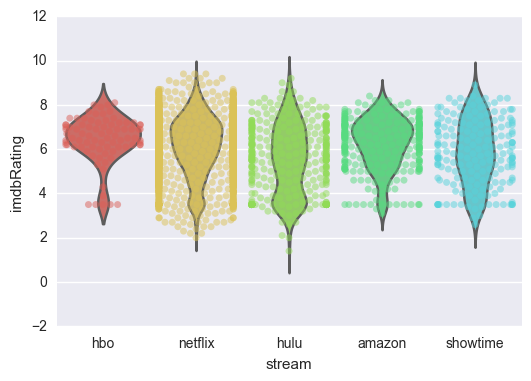

In [199]:
streamavg = service_rating[['netflix', 'amazon', 'hbo', 'showtime', 'hulu', 'imdbRating']].query('amazon ==1 or netflix ==1 or hbo ==1 or hulu ==1 or showtime==1')
streamlist = ['netflix', 'amazon', 'hbo', 'showtime', 'hulu'] 
meanratings = []
streamcount = []
streamavg

hbo = streamavg[['hbo', 'imdbRating']].query('hbo ==1')
hbo['stream'] = 'hbo'   
hbo.drop('hbo', axis=1, inplace=True)
amazon = streamavg[['amazon', 'imdbRating']].query('amazon ==1')
amazon['stream'] = 'amazon'  
amazon.drop('amazon', axis=1, inplace=True)
showtime = streamavg[['showtime', 'imdbRating']].query('showtime ==1')
showtime['stream'] = 'showtime'  
showtime.drop('showtime', axis=1, inplace=True)
hulu = streamavg[['hulu', 'imdbRating']].query('hulu ==1')
hulu['stream'] = 'hulu'  
hulu.drop('hulu', axis=1, inplace=True)
netflix = streamavg[['netflix', 'imdbRating']].query('netflix ==1')
netflix['stream'] = 'netflix' 
netflix.drop('netflix', axis=1, inplace=True)

frames = [hbo, netflix, hulu, amazon, showtime]

streamavg = pd.concat(frames)
streamavg


sns.violinplot(x="stream", y="imdbRating", data=streamavg, inner=None)
sns.swarmplot(x="stream", y="imdbRating", data=streamavg, alpha=.5)


In [109]:
# FinalMovieNorm_df['imdbRating'] = preprocessing.scale(FinalMovieNorm_df['imdbRating'])
FinalMovieNorm_df['tomatoMeter'] = preprocessing.scale(FinalMovieNorm_df['tomatoMeter'])
FinalMovieNorm_df['tomatoUserRating'] = preprocessing.scale(FinalMovieNorm_df['tomatoUserRating'])

In [110]:
indexvals = FinalMovieNorm_df.index.get_values()

In [111]:
#take cosine similarity of the features of every movie with those of every other movie
#result is a distance grid where intersection of row in column is cosine of the angle 
#between vectors in nth-feature dimension
#where movie intersects with itself cosine similarity (cosine of 0degree) is equal to one

from sklearn.metrics.pairwise import cosine_similarity

movieEuc1_df = cosine_similarity(FinalMovieNorm_df, FinalMovieNorm_df)

In [112]:
#convert dataframe to grid

cosinedist_df = pd.DataFrame(movieEuc1_df)

In [113]:
#concatenate grid with key dataframe for reference

cosinedist_df = pd.concat([cosinedist_df, key_df], axis=1)

In [114]:
#create sample of cosine similarity for 10 movies

sampletitles = ['Ice Age', 'Inside Out', 'Aladdin', 'Legally Blonde', 'The Devil Wears Prada',\
               'Mission: Impossible', 'Bourne Identity', 'Scream', 'Halloween', 'Cabin in the Woods']

In [115]:
from urllib2 import urlopen
indexnums = []
for movie in sampletitles:
    api = movie.replace(' ', '+')
    movies = urlopen("http://www.omdbapi.com/?t={}&plot=short&r=json&tomatoes=true".format(api))
    results = movies.read()
    response_dict = eval(results)
    ID = response_dict['imdbID']
    indexnums.append(cosinedist_df[cosinedist_df['imdbID'] == ID].index.tolist())


In [116]:
sample_movies = pd.DataFrame()
for sample in indexnums:
    sample_movies = pd.concat([sample_movies, FinalMovieNorm_df.loc[sample]])

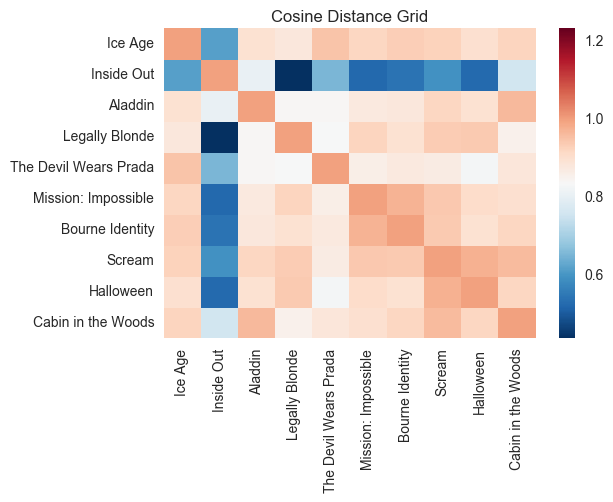

In [117]:
movieEucSample_df = cosine_similarity(sample_movies, sample_movies)

cosinedistSample_df = pd.DataFrame(movieEucSample_df)
cosinedistSample_df.index = sampletitles
cosinedistSample_df.columns = sampletitles
ax = plt.axes()
sns.heatmap(cosinedistSample_df, center=cosinedistSample_df.loc["Legally Blonde", "The Devil Wears Prada"], ax = ax)
ax.set_title('Cosine Distance Grid')

In [118]:
#td-idf of the plots of every movie

with open('SVD.pkl', 'r') as picklefile:
    SVD = pickle.load(picklefile)   
SVD

,0,1,2,3,4,5,6,7,8,9,...,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499
0,0.055016,-0.028894,-0.051558,0.044309,-0.042716,-0.008430,0.044556,0.009379,-0.041249,0.036186,...,0.001269,0.001897,-0.012087,-0.002395,0.013211,0.004483,0.004115,0.005344,0.014190,-0.007551
1,0.063279,0.030677,0.006669,-0.023913,-0.018732,-0.051354,-0.045093,0.075020,0.014348,-0.006560,...,0.001997,-0.002991,0.002529,-0.001606,0.002460,-0.006110,-0.008772,0.007294,0.008108,-0.000367
2,0.066550,-0.041060,-0.038789,0.054565,-0.051463,-0.028662,0.020038,0.002572,-0.003784,-0.007135,...,0.003389,-0.005152,-0.002926,0.000517,-0.001291,0.000289,-0.004182,-0.005181,0.002044,0.005374
3,0.075355,-0.060769,0.084881,0.039359,0.013330,0.018560,-0.015387,0.012562,0.024878,0.062243,...,-0.002073,0.002246,-0.002093,0.001024,-0.001912,-0.000904,0.006124,0.017811,0.006331,-0.002273
4,0.048551,0.006306,-0.015996,-0.013770,0.012620,-0.023674,0.013939,0.000771,0.026116,-0.051092,...,0.005328,-0.004600,0.001021,-0.009898,0.003595,0.000265,0.000579,0.008901,-0.009353,0.007229
5,0.050671,-0.035929,-0.004214,-0.004075,-0.037209,-0.005126,-0.036409,-0.017114,0.037806,-0.025604,...,-0.011402,0.009539,0.002083,-0.005868,-0.006765,0.006013,-0.001729,-0.001182,0.001424,0.010502
6,0.030948,-0.004166,-0.010379,-0.003223,0.002670,-0.001720,-0.004709,-0.004362,0.007561,-0.008650,...,0.016380,-0.014438,-0.000970,-0.005741,0.007688,0.001422,-0.003527,-0.003832,0.005885,0.003855
7,0.044553,0.027545,-0.003450,-0.019130,-0.012116,-0.040858,-0.033655,0.052108,0.016293,-0.009908,...,0.001177,0.000364,0.000092,0.003917,0.009349,0.000375,-0.003018,-0.000462,0.000656,-0.000213
8,0.033550,-0.027779,0.011361,-0.012840,-0.022746,0.003317,-0.024337,-0.007258,0.010078,-0.007905,...,0.004805,0.008033,-0.000180,0.001427,-0.006871,0.001130,0.005610,0.006593,-0.002897,0.005008
9,0.039712,-0.025369,0.015708,-0.013820,-0.028085,-0.012826,-0.012338,-0.008821,0.011631,-0.024632,...,0.000311,-0.001623,0.006998,0.002146,-0.001235,-0.001820,0.004519,0.005148,0.007903,0.002958


In [119]:
#This will be the front-end application for my recommendation engine

netflix = raw_input('Do you have a subscription to Netflix? yes/no : ')
hulu = raw_input('What about Hulu? yes/no : ')
hbo = raw_input('And HBO? yes/no : ')
amazon = raw_input('Are you lucky enough to have Amazon? yes/no : ')
showtime = raw_input("What's your Showtime status? yes/no : ")
movie = raw_input("Now, name a movie you'd like to watch : ")

Do you have a subscription to Netflix? yes/no : yes
What about Hulu? yes/no : yes
And HBO? yes/no : yes
Are you lucky enough to have Amazon? yes/no : yes
What's your Showtime status? yes/no : yes
Now, name a movie you'd like to watch : Amy


In [120]:
#use movie selection from user, search movie data with imdb API
#using the imdbID from output, search through the key that was concatenated with key for ID
#return index of that row and print content of movie

from urllib2 import urlopen
api = movie.replace(' ', '+')
movies = urlopen("http://www.omdbapi.com/?t={}&plot=short&r=json&tomatoes=true".format(api))
results = movies.read()
response_dict = eval(results)
ID = response_dict['imdbID']

index_num = cosinedist_df[cosinedist_df['imdbID'] == ID].index.tolist()

response_dict

{'Actors': 'Amy Winehouse, Lauren Gilbert, Juliette Ashby, Nick Shymansky',
 'Awards': 'Won 1 Oscar. Another 48 wins & 38 nominations.',
 'BoxOffice': '$7,851,076.00',
 'Country': 'UK, USA',
 'DVD': '01 Dec 2015',
 'Director': 'Asif Kapadia',
 'Genre': 'Documentary, Biography, Music',
 'Language': 'English',
 'Metascore': '85',
 'Plot': 'Archival footage and personal testimonials present an intimate portrait of the life and career of British singer/songwriter Amy Winehouse.',
 'Poster': 'https://images-na.ssl-images-amazon.com/images/M/MV5BMTQ1MzE4MTE3OF5BMl5BanBnXkFtZTgwOTcyNDM3NTE@._V1_SX300.jpg',
 'Production': 'A24 Films',
 'Rated': 'R',
 'Released': '03 Jul 2015',
 'Response': 'True',
 'Runtime': '128 min',
 'Title': 'Amy',
 'Type': 'movie',
 'Website': 'http://amy-movie.com/',
 'Writer': 'N/A',
 'Year': '2015',
 'imdbID': 'tt2870648',
 'imdbRating': '7.8',
 'imdbVotes': '33,948',
 'tomatoConsensus': 'As riveting as it is sad, Amy is a powerfully honest look at the twisted relatio

In [121]:
#calculate cosine similarity of each movie in tf-idf dataframe with the movie selected

plotNLP = cosine_similarity(SVD, SVD.loc[index_num])
plotNLP_df = pd.DataFrame(plotNLP)

In [122]:
#save the row of cosine similarites to a list

b=plotNLP_df.iloc[:,:].values
b=b.tolist()

In [123]:
#sum values of NLP cosine similarities with content cosine similarities on every row 
#of selected movie column

cosinedistmodel_df = cosinedist_df
a = cosinedistmodel_df[index_num].values.tolist()
c = [x+y for x,y in zip(a, b)]

adjustedsim = []
for x in range(len(c)):
    d = c[x][0] + 4*(c[x][1])
    adjustedsim.append(d)

adjustedsim

[0.4998234543432746,
 0.6570710843304708,
 0.6216676553595178,
 0.77578879213941,
 0.6187085591353827,
 0.685169327438443,
 0.6560675214892827,
 0.5793405512289842,
 0.6001434566825394,
 0.6427676418064343,
 0.6900916546991913,
 0.5314861749217099,
 0.7392709498042578,
 0.6935682449400771,
 0.5799865233646733,
 0.6195859725536027,
 0.9462401507544471,
 0.6309420885345701,
 0.6806827140174735,
 0.5804782726355227,
 0.7698715976027071,
 0.6874650129161765,
 0.6124224327376423,
 0.6433113115751635,
 0.9510036976098475,
 0.7119245750768143,
 0.6367957438802366,
 0.7676251202770766,
 0.7081231057271794,
 0.6816197303350018,
 0.6984186269086089,
 0.5820683725170192,
 0.5891590206029206,
 0.8862951126543048,
 0.6990992060013647,
 0.9115184254850662,
 0.5928225476656959,
 0.5577009077012527,
 0.7445554679137175,
 0.6719674818400977,
 0.722608955048884,
 0.8832818807632332,
 0.7078765619156925,
 0.6037021373804323,
 0.7789174549045631,
 0.698148642422329,
 0.7328970226939102,
 0.799701810056866

In [124]:
#update that column in main dataframe

cosinedistmodel_df[index_num] = adjustedsim

In [125]:
#intialize empty dataframe

available_movies = pd.DataFrame()

In [126]:
import numpy as np
#take subsets of main dataframe and append them to available_movies dataframe
#these will make up the space in which I am looking for the most similar movie

servicelist = []
if hbo == 'yes':
    hborows = cosinedistmodel_df.loc[cosinedistmodel_df['hbo'] == 1.0]
    available_movies = pd.concat([available_movies, hborows])
if hulu == 'yes':
    hulurows = cosinedistmodel_df.loc[cosinedistmodel_df['hulu'] == 1.0]
    available_movies = pd.concat([available_movies, hulurows])
if netflix == 'yes':
    netflixrows = cosinedistmodel_df.loc[cosinedistmodel_df['netflix'] == 1.0]
    available_movies = pd.concat([available_movies, netflixrows])
if showtime == 'yes':
    showtimerows = cosinedistmodel_df.loc[cosinedistmodel_df['showtime'] == 1.0]
    available_movies = pd.concat([available_movies, showtimerows])
if amazon == 'yes':
    amazonrows = cosinedistmodel_df.loc[cosinedistmodel_df['amazon'] == 1.0]
    available_movies = pd.concat([available_movies, amazonrows])

In [127]:
#take out the key in dataframe

wo_services = available_movies.iloc[:,0:-6]

#find row index with largest value in the column specified

suggest_movierow = wo_services[index_num].idxmax(axis=0)

#on the row index return ID from imdbID column which will be used to search for movie name
suggest_movieID = available_movies['imdbID'][suggest_movierow]
suggest_movieID = suggest_movieID.to_string().replace(' ', '')[-9:]
        
#look through key to return the sites where movie can be found
returnservice = key_df.iloc[suggest_movierow]

streaminglist = []

if int(returnservice['netflix']) == 1:
    streaminglist.append('netflix')
if int(returnservice['hulu']) == 1:
    streaminglist.append('hulu')
if int(returnservice['hbo']) == 1:
    streaminglist.append('hbo')
if int(returnservice['amazon']) == 1:
    streaminglist.append('amazon')
if int(returnservice['showtime']) == 1:
    streaminglist.append('showtime')


In [131]:
#Print out the recommender results

movie_info = urlopen("http://www.omdbapi.com/?i={}&plot=short&r=json".format(suggest_movieID))
results = movie_info.read()
response_dict = eval(results)
title = response_dict['Title']

In [140]:
#print the streaming website where it can be found
import os

for site in streaminglist:
    print 'Movie found on ' + site
    os.system('say Hey you, your recommendation is ready')

Movie found on amazon
